## Example: Applying TigerTail to Anonymous Student Data

In this notebook, we apply the TigerTail library to a dataset of anonymous student data downloaded from https://zenodo.org/records/4114005. Each row of this dataset contains information for a certain student (specified by the `anon_id` feature) at a certain semester (specified by the `semester_idx` feature). The student information includes static and dynamic features such as `female`, `changed_major`, and `major_gpa`.

The eventual goal is to predict the `changed_major` feature (when a student changes majors) using the other features. This notebook shows how to use TigerTail classes to help visualize patterns in data when a student changes their major.

First we import the necessary libraries and load in the data:

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '../TT')
from tigertail import TimeFrame, TimeSeries, EventSeries

In [2]:
data_path = '../data/anon_student_data.csv'
student_df = pd.read_csv(data_path)
student_df

,first_course_year,semester_idx,female,white_asian,start_age,first_gen,HS_Zip_Code,changed_major,n_majors,total_semester_credit_hours,...,Geography,Median income (dollars); Estimate; Households,Median income (dollars); Margin of Error; Households,Number; Estimate; FAMILIES - Families,Number; Margin of Error; FAMILIES - Families,Median income (dollars); Estimate; FAMILIES - Families,Median income (dollars); Margin of Error; FAMILIES - Families,zipstr,zip_median_income_log,anon_id
0,13.0,1.0,1.0,1.0,19.0,0.0,NaN,0.0,1.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125713
1,17.0,1.0,1.0,1.0,18.0,1.0,48867,0.0,2.0,14.0,...,ZCTA5 48867,43388.0,2198.0,7417.0,211.0,56442.0,4490.0,48867.0,4.751602,160343
2,3.0,1.0,0.0,1.0,26.0,0.0,NaN,0.0,1.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34721
3,0.0,1.0,0.0,1.0,18.0,0.0,34652,0.0,1.0,15.0,...,ZCTA5 34652,36329.0,3082.0,5958.0,369.0,48205.0,3885.0,34652.0,4.683092,6446
4,9.0,1.0,0.0,1.0,18.0,0.0,48346,0.0,1.0,15.0,...,ZCTA5 48346,74958.0,5627.0,6288.0,294.0,88802.0,7348.0,48346.0,4.948423,84932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553519,9.0,16.0,1.0,1.0,18.0,0.0,60030,0.0,1.0,13.0,...,ZCTA5 60030,83680.0,3258.0,9698.0,290.0,105239.0,4370.0,60030.0,5.022177,91426
1553520,8.0,16.0,1.0,1.0,18.0,0.0,48820,0.0,1.0,5.0,...,ZCTA5 48820,82964.0,3961.0,4905.0,238.0,96399.0,5734.0,48820.0,4.984073,78620
1553521,5.0,16.0,0.0,0.0,19.0,0.0,20011,0.0,1.0,6.0,...,ZCTA5 20011,65327.0,3261.0,13424.0,493.0,85369.0,8525.0,20011.0,4.931300,55141
1553522,16.0,16.0,1.0,1.0,19.0,1.0,48161,0.0,8.0,20.0,...,ZCTA5 48161,49627.0,3809.0,7110.0,251.0,61250.0,3619.0,48161.0,4.787106,152752


Now we create a dataframe with just the features `semester_idx`, `anon_id`, `major_gpa`, `cumulative_credit_hours`, and `nonmajor_credits`:

In [3]:
some_features_df = student_df[['semester_idx', 'anon_id', 'major_gpa', 'cumulative_credit_hours', 'nonmajor_credits']]
some_features_df

,semester_idx,anon_id,major_gpa,cumulative_credit_hours,nonmajor_credits
0,1.0,125713,0.000000,14.0,14.0
1,1.0,160343,1.500000,14.0,8.0
2,1.0,34721,2.333333,10.0,3.0
3,1.0,6446,0.000000,15.0,15.0
4,1.0,84932,1.300000,15.0,12.0
...,...,...,...,...,...
1553519,16.0,91426,1.500000,138.0,6.0
1553520,16.0,78620,3.250000,145.0,0.0
1553521,16.0,55141,2.000000,95.0,2.0
1553522,16.0,152752,1.083333,177.0,13.0


From this point on, we will limit our demonstration to just 2 students' data for simplicity. (We picked 2 students, 111292 and 21013, whose data showed that they changed majors at some point.)

First, we prepare separate dataframes, one for each feature of the students' data (for example, one TimeSeries object contains the `major_gpa` data for student 21013).

In [4]:
student_111292_mask = some_features_df['anon_id'] == 111292
student_21013_mask = some_features_df['anon_id'] == 21013

major_gpa_df_111292 = pd.DataFrame(some_features_df[student_111292_mask]).drop(['cumulative_credit_hours', 'nonmajor_credits', 'anon_id'], axis=1).set_index('semester_idx')
credit_hrs_df_111292 = pd.DataFrame(some_features_df[student_111292_mask]).drop(['major_gpa', 'nonmajor_credits', 'anon_id'], axis=1).set_index('semester_idx')
nonmajor_credits_df_111292 = pd.DataFrame(some_features_df[student_111292_mask]).drop(['cumulative_credit_hours', 'major_gpa', 'anon_id'], axis=1).set_index('semester_idx')

major_gpa_df_21013 = pd.DataFrame(some_features_df[student_21013_mask]).drop(['cumulative_credit_hours', 'nonmajor_credits', 'anon_id'], axis=1).set_index('semester_idx')
credit_hrs_df_21013 = pd.DataFrame(some_features_df[student_21013_mask]).drop(['major_gpa', 'nonmajor_credits', 'anon_id'], axis=1).set_index('semester_idx')
nonmajor_credits_df_21013 = pd.DataFrame(some_features_df[student_21013_mask]).drop(['cumulative_credit_hours', 'major_gpa', 'anon_id'], axis=1).set_index('semester_idx')

major_gpa_df_111292

,major_gpa
semester_idx,
1.0,0.7
2.0,0.0
3.0,1.6
4.0,1.5
5.0,0.0
6.0,1.6
7.0,2.4
9.0,2.4
10.0,2.0


Then we create TimeSeries objects from those dataframes:

In [5]:
major_gpa_ts_111292 = TimeSeries(major_gpa_df_111292, agg_func=np.mean)
credit_hrs_ts_111292 = TimeSeries(credit_hrs_df_111292, agg_func=np.mean)
nonmajor_credits_ts_111292 = TimeSeries(nonmajor_credits_df_111292, agg_func=np.mean)

major_gpa_ts_21013 = TimeSeries(major_gpa_df_21013, agg_func=np.mean)
credit_hrs_ts_21013 = TimeSeries(credit_hrs_df_21013, agg_func=np.mean)
nonmajor_credits_ts_21013 = TimeSeries(nonmajor_credits_df_21013, agg_func=np.mean)

Now we visualize the data:

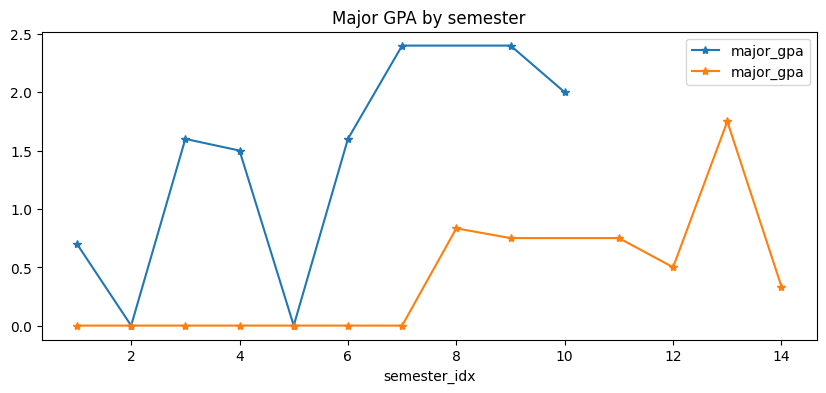

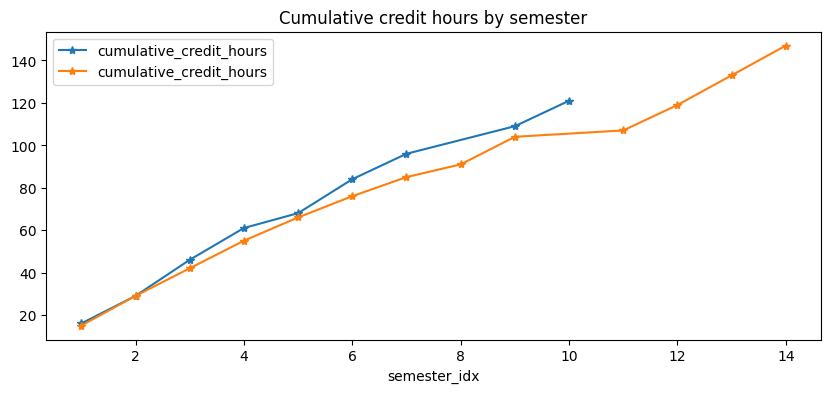

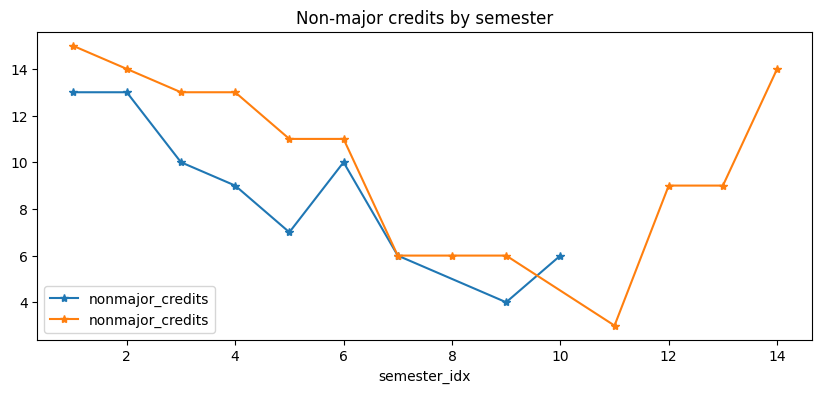

In [6]:
ax = major_gpa_ts_111292.data.plot(marker='*', label='111292', figsize=(10,4))
major_gpa_ts_21013.data.plot(marker='*', label='21013', figsize=(10,4), ax=ax)
plt.legend()
plt.title("Major GPA by semester")
plt.show()

ax = credit_hrs_ts_111292.data.plot(marker='*', label='111292', figsize=(10,4))
credit_hrs_ts_21013.data.plot(marker='*', label='21013', figsize=(10,4), ax=ax)
plt.legend()
plt.title("Cumulative credit hours by semester")
plt.show()

ax = nonmajor_credits_ts_111292.data.plot(marker='*', label='111292', figsize=(10,4))
nonmajor_credits_ts_21013.data.plot(marker='*', label='21013', figsize=(10,4), ax=ax)
plt.legend()
plt.title("Non-major credits by semester")
plt.show()

Now we create a dataframe containing the `changed_major` values for the 2 students, and then use that dataframe to create an EventSeries object for each student.

In [7]:
changed_major_df = student_df[['semester_idx', 'changed_major', 'anon_id']]
student_mask = (changed_major_df['anon_id'] == 21013) | (changed_major_df['anon_id'] == 111292)
changed_major_df = pd.DataFrame(changed_major_df[student_mask]).set_index('anon_id')
changed_major_df

,semester_idx,changed_major
anon_id,,
21013,1.0,0.0
21013,2.0,1.0
21013,3.0,0.0
21013,4.0,0.0
21013,5.0,0.0
21013,6.0,0.0
21013,7.0,0.0
21013,8.0,1.0
21013,9.0,0.0


In [8]:
student_21013_mask = changed_major_df.index == 21013
changed_major_21013_df = changed_major_df[student_21013_mask]
changed_major_21013_df.index = changed_major_21013_df['semester_idx']
changed_major_mask = changed_major_21013_df['changed_major'] == 1
changed_major_21013_df = pd.DataFrame(changed_major_21013_df[changed_major_mask])
changed_major_21013_df = changed_major_21013_df.drop('semester_idx', axis=1)

print(changed_major_21013_df)

student_21013_es = EventSeries(changed_major_21013_df)

              changed_major
semester_idx               
2.0                     1.0
8.0                     1.0


In [9]:
student_111292_mask = changed_major_df.index == 111292
changed_major_111292_df = changed_major_df[student_111292_mask]
changed_major_111292_df.index = changed_major_111292_df['semester_idx']
changed_major_mask = changed_major_111292_df['changed_major'] == 1
changed_major_111292_df = pd.DataFrame(changed_major_111292_df[changed_major_mask])
changed_major_111292_df = changed_major_111292_df.drop('semester_idx', axis=1)

print(changed_major_111292_df)

student_111292_es = EventSeries(changed_major_111292_df)

              changed_major
semester_idx               
2.0                     1.0


We can see that each of these students changed majors in semester 2, and student 21013 changed majors again in semester 8, so we would want to look at trends in features like `nonmajor_credits` and `cumulative_credit_hours` leading up to the semesters when the students changed major.

We now create 2 separate TimeFrame objects for student 21013 and student 111292 to demonstrate how to use the TimeFrame window function to window the `nonmajor_credits` and `cumulative_credit_hours` feature data according to the major change event timestamps.

In [10]:
student_21013_tf = TimeFrame()
student_21013_tf['student_21013_es'] = student_21013_es
# student_21013_df = pd.DataFrame(some_students_df[some_students_df.index == 21013]).drop(['cumulative_credit_hours', 'nonmajor_credits'], axis=1).set_index('semester_idx')
# print(student_21013_df)
student_21013_tf['student_21013_major_gpa'] = major_gpa_ts_21013
student_21013_tf['student_21013_credit_hrs'] = credit_hrs_ts_21013
student_21013_tf['student_21013_nonmajor_credits'] = nonmajor_credits_ts_21013

In [11]:
student_111292_tf = TimeFrame()
student_111292_tf['student_111292_es'] = student_111292_es
# student_111292_df = pd.DataFrame(some_students_df[some_students_df.index == 111292]).drop(['cumulative_credit_hours', 'nonmajor_credits'], axis=1).set_index('semester_idx')
# print(student_111292_df)
student_111292_tf['student_111292_major_gpa'] = major_gpa_ts_111292
student_111292_tf['student_111292_credit_hrs'] = credit_hrs_ts_111292
student_111292_tf['student_111292_nonmajor_credits'] = nonmajor_credits_ts_111292

Now we can actually window the time series data by the event timestamps using the `TimeFrame` window function:

In [12]:
student_21013_tf.window(freq=student_21013_es)

,changed_major,major_gpa,cumulative_credit_hours,nonmajor_credits
2.0,1.0,0.000000,22.000000,14.5
8.0,1.0,0.138889,69.166667,10.0


In [13]:
student_111292_tf.window(freq=student_111292_es)

,changed_major,major_gpa,cumulative_credit_hours,nonmajor_credits
2.0,1.0,0.35,22.5,13.0
